In [3]:
import time
import torch

from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset

import flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper
from Distributions2 import *
# visualization
import matplotlib.pyplot as plt
from models.model_configs import instantiate_model
from matplotlib import cm
from flow import build_ttf_m
from network import MLP,MLP_TailParam,MLP_TailParam2,MLP2,BigTimeConditionalNet,TimeToVecNet,FullConnectedScoreModel,FullConnectedScoreModel_time
from torch.autograd.functional import jacobian
from torch.distributions import Independent, Normal
from extreme_transforms import TailAffineMarginalTransform_SeparateNetParam2   
from scaler_grad import NativeScalerWithGradNormCount as NativeScaler
# To avoide meshgrid warning
import warnings
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec


warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [4]:

approach=2

In [6]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)
seed=42

Using gpu


## Sampling data

In [7]:
import numpy as np

def train_test_split(data, test_ratio=0.5, seed=None):
    """
    Splits BxD data into train and test sets in a 9:1 ratio by default.

    Args:
        data (np.ndarray): Input array of shape (B, D).
        test_ratio (float): Proportion of the data to use for the test set.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        train_data (np.ndarray), test_data (np.ndarray)
    """
    if seed is not None:
        np.random.seed(seed)
    
    B = data.shape[0]
    indices = np.random.permutation(B)
    test_size = int(B * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return data[train_indices], data[test_indices]


In [8]:
Dataset="studentT"#studentT,one,pareto,Bike,queue,stock,gmm,hrrr
option="simpletail"
option_model='simplemodel'

In [6]:
# dof_og=1
# n_hidden_layers=2
# full_data,objectz=samplestudentT_4(50,dof_og,40000) #40000 x 2
# full_data.max(),full_data.min()

In [10]:
from distribution_DLIM import sample_grid_gmm

# import matplotlib.pyplot as plt

# weight=[
#         0.01,
#         0.1,
#         0.3,
#         0.2,
#         0.02,
#         0.15,
#         0.02,
#         0.15,
#         0.05
#     ]
# d=sample_grid_gmm(320,1.7,3,0.1,3,weight,'cpu',False,True,False,1)

# plt.scatter(d[:,0],d[:,1])


In [13]:
#PRINT MIX OF STUDENT-T
from generate_splits import generate_data_split
if Dataset=="studentT": #perfect
    dof_og=1
    n_hidden_layers=2
    full_data,objectz=samplestudentT_4(50,dof_og,40000) #40000 x 2
    print(full_data.max(),full_data.min())
    Data_Splt=generate_data_split('gppg', seed, 'dummy',full_data)
    trn_ix = Data_Splt["split"]["trn"]
    val_ix = Data_Splt["split"]["val"]
    tst_ix = Data_Splt["split"]["tst"]
    full_data_train =full_data[trn_ix]   
    full_data_test =full_data[tst_ix] 
    full_data_val=full_data_train#full_data[val_ix]
    x_lim=y_lim=80
    iterations=800*2
    hidden_dim=512
    batch_size = 4096
    # full_data_train,full_data_test=train_test_split(full_data,seed=seed,test_ratio=0.5)
    dimension=2
elif Dataset=="pareto": #perfect
    iterations=800*4
    dimension=20
    full_data = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\pareto\\pareto_20d_data.npy').reshape(-1,20)[0:30000,0:dimension] #(100000, 20)
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    print(full_data_train.shape)
    hidden_dim=256
    n_hidden_layers=2
    x_lim=y_lim=8
    batch_size = 4096*2
elif Dataset=='funnel':
    dimension=2
    n_hidden_layers=2
    full_data=sample_funnel(30000)
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    print(full_data_train.shape)
    x_lim=20
    y_lim=20
    iterations=1600
    hidden_dim=512
    batch_size = 4096*2
        
elif Dataset=='queue':
    dimension=20
    full_data = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\queue\\queue_data_20d.npy')[0:90000,0,0:dimension]
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    
    print(full_data_train.shape)
    x_lim=y_lim=200
    iterations=1200
    hidden_dim=256  #128 for 12
    n_hidden_layers=6
elif Dataset=="Stock":
    full_data_train = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\stock\\stock_data_train_20.npy').reshape(-1,20)# 1200,20
    full_data_test = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\stock\\stock_data_test_20.npy').reshape(-1,20)# 282,20
    full_data_val=full_data_train
    dimension=20
    print(full_data_train.shape)
    x_lim=y_lim=20
    iterations=1800
    hidden_dim=128
    n_hidden_layers=2
elif Dataset=='gmm':
    full_data=sample_grid_gmm(48000,1.7,3,0.1,3,weight,'cpu',False,True,False,1)
    dimension=2
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    x_lim=y_lim=200
    iterations=1600
    hidden_dim=128
elif Dataset=='hrrr':
    full_data_train =  torch.tensor(np.load('hrr_train_32.npy')[:,:,5:10,8:10])
    full_data_test = torch.tensor(np.load('hrr_test_32.npy')[:,:,5:10,8:10])
    xz=full_data_train

    full_data_test=full_data_test.reshape(full_data_test.shape[0],-1)
    full_data_train=full_data_train.reshape(full_data_train.shape[0],-1)
    
    full_data_train = ((full_data_train[:,:]-full_data_train.mean(0).unsqueeze(0)))/(full_data_train.std(0).unsqueeze(0))
    full_data_test = ((full_data_test[:,:]-full_data_test.mean(0).unsqueeze(0)))/(full_data_test.std(0).unsqueeze(0))


    
    print(full_data_train.shape,full_data_test.shape)
    full_data_val=full_data_train
    dimension=20
    print(full_data_train.shape)
    x_lim=y_lim=20
    iterations=800*4
    hidden_dim=128
    n_hidden_layers=2
    batch_size=4096

    




tensor(13218.0273) tensor(-8026.5181)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:54<00:00, 27.26s/it]


In [16]:
full_data_train[:,0].min(),full_data_test[:,0].min()

(tensor(-7542.4233), tensor(-2635.1338))

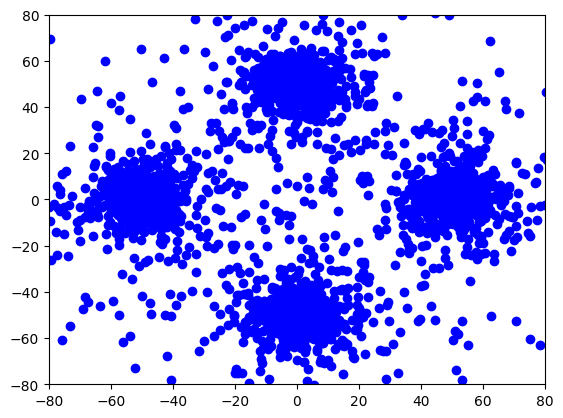

In [18]:
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-1*x_lim,x_lim))
plt.scatter(full_data_train[:,0],full_data_train[:,1],c="blue")
# full_data.max(),full_data.min()
# plt.hist(full_data_train[:,0],label='aa',bins=100)
# plt.hist(full_data_test[:,0],label='a',bins=100)



In [ ]:
# xz.shape


In [20]:
# # Generate some 2D data
# x=torch.tensor(full_data_train)
# x = ((full_data_train[:,:]-full_data_train.mean(0).unsqueeze(0)))/(full_data_train).std(0).unsqueeze(0)
# x=x.reshape(x.shape[0],2,5,2)
# print(x.shape)
# print(full_data_test.min(),full_data_test.max())
# y = full_data_test[:,1]
# # plt.xlim((-1*0.1,0.1))

# plt.hist(y,histtype='step',density=True,bins=100)
# plt.hist(xz[:,0,2,1].reshape(xz.shape[0],-1),bins=100)



In [21]:
full_data_train.max(),full_data_test.max()

(tensor(6212.2803), tensor(3213.1848))

## Building the  Model

In [22]:
dimension

2

In [23]:
if option_model=='simplemodel':
    print("simplemodel")
    # model=BigTimeConditionalNet(input_dim=dimension, time_dim=dimension, hidden_dim=hidden_dim).to(device)
    # model=MLP2(input_dim=dimension, time_dim=1, hidden_dim=hidden_dim).to(device) #PREVECTOR FIELD
    model=MLP(input_dim=dimension, time_dim=1, hidden_dim=hidden_dim).to(device) #best of StudentT ,cone
    # model=FullConnectedScoreModel(dimension,hidden_dim,n_hidden_layers).to(device)#best for pareto
else:
    model = instantiate_model(
        architechture='studentT',
        is_discrete=False,
        use_ema=True,
    ).to(device)


if option=='simpletail':
    # Tail_paramNet=TimeToVecNet(1,hidden_dim,4*dimension).to(device)
    # Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE  #best of StudentT,Pareto
    Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE   ,cone

    # Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE #
    # Tail_paramNet=FullConnectedScoreModel_time(dimension,hidden_dim//2,n_hidden_layers//2).to(device)
    print("simple")
else:
    Tail_paramNet=instantiate_model(
    architechture=Dataset+'_tail',   #CHANGE MAYBE
    is_discrete=False,
    use_ema=True,
        ).to(device)
noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=dimension).to(device)  


simplemodel
simple


In [15]:
# model(torch.randn(5,1,20),torch.randn(5),extra=[]).shape,Tail_paramNet(torch.randn(5,1,20),torch.randn(5),extra=[]).shape

In [16]:
# noise2data(torch.zeros(6,2),torch.zeros(6,8)).shape

In [24]:
lr = 0.0001

print_every = 10


In [25]:
train_dataset = TensorDataset(torch.tensor(full_data_train))


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\adity\AppData\Local\Temp\ipykernel_26300\4294779823.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(full_data_train))


In [26]:
jo=0 #counter
path = AffineProbPath(scheduler=CondOTScheduler())


optim = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-3)
optim2=torch.optim.Adam(Tail_paramNet.parameters(), lr=lr,weight_decay=1e-3)#,weight_decay=1e-3)
loss_scaler = NativeScaler()
# scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=lr, end_factor=0.0, total_iters=iterations*len(train_loader))
# scheduler2 = torch.optim.lr_scheduler.LinearLR(optim2, start_factor=lr, end_factor=0.0, total_iters=iterations*len(train_loader))



c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\scaler_grad.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


In [27]:
dim=dimension
dimx=dimension

In [29]:
from typing import Callable
from torch import nn, Tensor

def jvp(f,x, v) -> tuple[Tensor, ...]:
    return torch.autograd.functional.jvp(
        f, x, v, 
        create_graph=torch.is_grad_enabled()
    )


def t_dir(f, t) -> tuple[Tensor, ...]:
    return jvp(f, t, torch.ones_like(t))


def get_t_dir(dimension,noise2data,Model, x: Tensor, t: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
    def flow(Xz,timez):
        # print("XZ_t",Xz.shape,timez.shape)
        param_tail_eps=Model(timez.unsqueeze(1))
        dummy_tail_param2=param_tail_eps.reshape(param_tail_eps.shape[0],4,dimension)
        _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = dummy_tail_param2[:,0,:],dummy_tail_param2[:,1,:],dummy_tail_param2[:,2,:],dummy_tail_param2[:,3,:]

        D1=noise2data.pos_tail(_unc_pos_tail2)
        D2=noise2data.neg_tail(_unc_neg_tail2)
        D3=shift2
        D4=noise2data.scale(_unc_scale2)   

        valuez=torch.cat([D1,D2,D3,D4],1)

        return(valuez)









    def f(x_in):
        def f_(t_in):
            return flow(x_in, t_in)
        return f_

    return t_dir(f(x), t)

In [32]:
class combined(nn.Module):
    def __init__(
        self,tail_param_net,PreVFnet,NOISE2DATA
    ):
        # self.features = features
        super(combined, self).__init__()
        self.tail_param_net=tail_param_net
        self.PreVFnet=PreVFnet
        self.NOISE2DATA=NOISE2DATA
    def forward(self, x_t,time_t):
        time_t=time_t.reshape(-1).expand(x_t.shape[0])
        lol=None
        if approach==1:
            if option_model=='simplemodel':
                prefinal_vf=self.PreVFnet(x_t,time_t)
            else:
                prefinal_vf=self.PreVFnet(x_t.unsqueeze(1),time_t,extra=[])
            prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1)
        if approach==2:        
        # print("x",x_t.shape,"timt=",time_t,time_t.shape,time_t.unsqueeze(1).shape)
            if option=='simpletail':
                param_tail=self.tail_param_net(time_t.unsqueeze(1)) #BX80

                True_timederiv=get_t_dir(dim,self.NOISE2DATA,self.tail_param_net,x_t,time_t)
                param_grad=True_timederiv[1] #time derive

            else:
                ones=torch.zeros(x_t.shape).to(device)+time_t.unsqueeze(1) #B X 20
                param_tail=self.tail_param_net(ones.unsqueeze(1),time_t,extra=[])  # B X 4 X 20 Generating Parameters of Tail net for each time step

            param_tail=param_tail.reshape(param_tail.shape[0],-1)
            param_tail_pre_eps=param_tail
            # print("param_tail",param_tail.shape)

            # print("LETSGO",x_t.shape,param_tail.shape)
            phi_t=self.NOISE2DATA.inverse(x_t,param_tail,False,None,None)
            if option_model=='simplemodel':
                prefinal_vf=self.PreVFnet(phi_t,time_t)
            else:
                prefinal_vf=self.PreVFnet(phi_t,time_t,extra=[])
            prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1)

            jacobian_phi=self.NOISE2DATA.fwd_dTTF_dz(phi_t, param_tail)
            jacobian_param_tail=self.NOISE2DATA.dTTF_dtailparam(phi_t, param_tail)

            '''
            if option=='simpletail':
                param_tail_eps=self.tail_param_net(time_t.unsqueeze(1)+epsilon) 
            else:
                param_tail_eps=self.tail_param_net(ones.unsqueeze(1)+epsilon,time_t+epsilon,extra=[])
            
            param_tail_eps=param_tail_eps.reshape(param_tail_eps.shape[0],-1)
            

            dummy_tail_param=param_tail_pre_eps.reshape(param_tail_pre_eps.shape[0],4,dimension)
            _unc_pos_tail,_unc_neg_tail,shift,_unc_scale =dummy_tail_param[:,0,:],dummy_tail_param[:,1,:],dummy_tail_param[:,2,:],dummy_tail_param[:,3,:]

            # _unc_pos_tail,_unc_neg_tail,shift,_unc_scale, = param_tail_pre_eps[:,0:dimx],param_tail_pre_eps[:,dimx:2*dimx],param_tail_pre_eps[:,2*dimx:3*dimx],param_tail_pre_eps[:,3*dimx:4*dimx]
            # _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = param_tail_eps[:,0:dimx],param_tail_eps[:,dimx:2*dimx],param_tail_eps[:,2*dimx:3*dimx],param_tail_eps[:,3*dimx:4*dimx]


            dummy_tail_param2=param_tail_eps.reshape(param_tail_eps.shape[0],4,dimension)
            _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = dummy_tail_param2[:,0,:],dummy_tail_param2[:,1,:],dummy_tail_param2[:,2,:],dummy_tail_param2[:,3,:]


            
            
            D1=(self.NOISE2DATA.pos_tail(_unc_pos_tail2)-self.NOISE2DATA.pos_tail(_unc_pos_tail))/epsilon
            D2=(self.NOISE2DATA.neg_tail(_unc_neg_tail2)-self.NOISE2DATA.neg_tail(_unc_neg_tail))/epsilon
            D3=(shift2-shift)/epsilon
            D4=(self.NOISE2DATA.scale(_unc_scale2)-self.NOISE2DATA.scale(_unc_scale))/epsilon

            param_grad=torch.cat([D1,D2,D3,D4],1)
            '''
            # print("param_grad",param_grad.shape)
            # print("HOLA",jacobian_param_tail.shape,param_grad.shape)
            first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
            second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2)
            # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
            # print(first_part.shape,second_part.shape)
            velocity_field=first_part+second_part
        elif approach==1:
            velocity_field=prefinal_vf
        # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
        return(velocity_field)
        
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)



def calc_Wassertein(MODEL,TAIL_PARAMNET,NOISE2DATA,VAL_DATASET,dimension):
    # step size for ode solver
    Combo=combined(TAIL_PARAMNET,MODEL,NOISE2DATA)
    wrapped_vf = WrappedModel(Combo)
    step_size = 0.05

 

    batch_size = VAL_DATASET.shape[0]  # batch size
 
    T = torch.linspace(0,1,10)  # sample times
    T = T.to(device=device)
    # print(a)

    x_init = torch.randn((batch_size, dimension), dtype=torch.float32, device=device)
    solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
    sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model
    generated_data=sol[9].cpu().numpy()
    validation_data=VAL_DATASET
    distance=np.mean(plot_wasserstein_distances(generated_data,validation_data))
    print(generated_data.shape,validation_data.shape,distance,"aloha")

    return distance

    


import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

def plot_wasserstein_distances(generate_data: np.ndarray, test_data: np.ndarray):
    """
    Computes and plots Wasserstein distances for each feature between generated and test data.

    Parameters:
    - generate_data: np.ndarray of shape (N, D)
    - test_data: np.ndarray of shape (N, D)
    """
    assert generate_data.shape[1] == test_data.shape[1], "Feature dimensions must match"
    num_features = generate_data.shape[1]
    
    distances = [
        wasserstein_distance(test_data[:, i], generate_data[:, i])
        for i in range(num_features)
    ]
    
    
    return distances  # Optional: return the distances for further use
 
    
   


In [ ]:

# train
start_time = time.time()
min_loss=9999999999

for iI in range(iterations):
    loss_epoch=0
    for data in train_loader:
        optim.zero_grad()
        optim2.zero_grad()

        x_1=data[0].float().to(device)   #batch x 20
        x_0 = torch.randn_like(x_1).float().to(device) #batch x 20

        # print("x_shape",x_0.shape,x_1.shape,x_1.mean())

        if iI<(3*iterations)//4:
            t = 1-torch.sqrt(1-torch.rand(x_1.shape[0])).to(device) #best
        else:
            t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)

        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        x_t,time_t,dx_t=path_sample.x_t,path_sample.t,path_sample.dx_t  #x_t- B X 20
        # print("x_t",x_t.shape)
        if approach==1:
            if option_model=='simplemodel':
                prefinal_vf=model(x_t,time_t)
            else:
                prefinal_vf=model(x_t.unsqueeze(1),time_t,extra=[])  #B X 1 X 20
            # print(prefinal_vf.shape)
            prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1) #B X 20
        # print("hello",prefinal_vf.shape)

        ones=torch.zeros(x_t.shape).to(device)+time_t.unsqueeze(1) #B X 20
        # print("ones",ones.shape,time_t.shape)

        if approach==2:
            if option=='simpletail':
                param_tail=Tail_paramNet(time_t.unsqueeze(1)) #BX80

                True_timederiv=get_t_dir(dim,noise2data,Tail_paramNet,x_t,time_t)
                param_grad=True_timederiv[1] #time derive
                # print("PARAM---",param_grad.min(),param_grad.max())
                # print(time_t.shape,True_timederiv[0].shape,True_timederiv[1].shape,param_tail.shape,param_grad.shape,"hallelja")
            else:
                param_tail=Tail_paramNet(ones.unsqueeze(1),time_t,extra=[])  # B X 4 X 20 Generating Parameters of Tail net for each time step

            print("param_tail",param_tail.shape,param_tail.max())
            param_tail=param_tail.reshape(param_tail.shape[0],-1)
            param_tail_pre_eps=param_tail


            phi_t=noise2data.inverse(x_t,param_tail,False,None,None)  #phi_t(x_0)  B X 20
            # print("phi_t",phi_t.shape,param_tail.shape) #BATCH X 2
            # print(a)

             
            if option_model=='simplemodel':
                prefinal_vf=model(phi_t,time_t)
            else:
                prefinal_vf=model(phi_t,time_t,extra=[])  #B X 1 X 20
            # print(prefinal_vf.shape)
            prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1) #B X 20        

            jacobian_phi=noise2data.fwd_dTTF_dz(phi_t, param_tail) #B X 20 X 20
            # print("jac_phi",jacobian_phi.shape)
            jacobian_param_tail=(noise2data.dTTF_dtailparam(phi_t, param_tail)) #list of 4  ,BX20
            # print(jacobian_param_tail[0].shape,"JPT0")


            '''
            epsilon=1e-4
            if option=='simpletail':
                param_tail_eps=Tail_paramNet(time_t.unsqueeze(1)+epsilon) 
            else:
                param_tail_eps=Tail_paramNet(ones.unsqueeze(1)+epsilon,time_t+epsilon,extra=[])
            param_tail_eps=param_tail_eps.reshape(param_tail_eps.shape[0],-1)
            # print("param_tail_pre_eps and param_tail_ems",param_tail_pre_eps.shape,param_tail_eps.shape)

            dummy_tail_param=param_tail_pre_eps.reshape(param_tail_pre_eps.shape[0],4,dimension)
            _unc_pos_tail,_unc_neg_tail,shift,_unc_scale =dummy_tail_param[:,0,:],dummy_tail_param[:,1,:],dummy_tail_param[:,2,:],dummy_tail_param[:,3,:]
            '''


            # _unc_pos_tail,_unc_neg_tail,shift,_unc_scale, = param_tail_pre_eps[:,0:dimx],param_tail_pre_eps[:,dimx:2*dimx],param_tail_pre_eps[:,2*dimx:3*dimx],param_tail_pre_eps[:,3*dimx:4*dimx]
            # _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = param_tail_eps[:,0:dimx],param_tail_eps[:,dimx:2*dimx],param_tail_eps[:,2*dimx:3*dimx],param_tail_eps[:,3*dimx:4*dimx]

            '''
            dummy_tail_param2=param_tail_eps.reshape(param_tail_eps.shape[0],4,dimension)
            _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = dummy_tail_param2[:,0,:],dummy_tail_param2[:,1,:],dummy_tail_param2[:,2,:],dummy_tail_param2[:,3,:]

            D1=(noise2data.pos_tail(_unc_pos_tail2)-noise2data.pos_tail(_unc_pos_tail))/epsilon
            D2=(noise2data.neg_tail(_unc_neg_tail2)-noise2data.neg_tail(_unc_neg_tail))/epsilon
            D3=(shift2-shift)/epsilon
            D4=(noise2data.scale(_unc_scale2)-noise2data.scale(_unc_scale))/epsilon

            param_grad=torch.cat([D1,D2,D3,D4],1) 
            '''

            # print("Param_grad",param_grad.shape) #BX80
            first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
            second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2)
            # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
            # print(first_part.shape,second_part.shape)
            velocity_field=first_part+second_part
        else:
            velocity_field=prefinal_vf

        
        loss = torch.pow( velocity_field - dx_t, 2).mean()#/(0.001+torch.abs(dx_t.max()))# remove the max division for math correct
        
        print(velocity_field.max(),dx_t.max(),loss)

        loss_scaler(
            loss,
            optim,
            optim2,
            parameters=model.parameters(),
            parameters2=Tail_paramNet.parameters(),
            update_grad=True,
            approach=approach
            )      
        # scheduler.step()
        # scheduler2.step()

    # log loss
        jo=jo+1
        if (jo+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(jo+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()
    if (iI+1)%50==0: 
        print("checking",iI)   
        model.eval()
        Tail_paramNet.eval()
        loss_epoch=calc_Wassertein(model,Tail_paramNet,noise2data,full_data_val,dimension)
        if loss_epoch<min_loss:
            min_loss=loss_epoch
            print("saving iteration-",iI)
            torch.save(Tail_paramNet.state_dict(), 'tailmodel_NEW.pth')
            torch.save(model.state_dict(),"model_NEW.pth")
            model.train()
            Tail_paramNet.train()
        

param_tail torch.Size([4096, 8]) tensor(0.2001, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(27.3665, device='cuda:0', grad_fn=<MaxBackward1>) tensor(6212.2866, device='cuda:0') tensor(13433.4258, device='cuda:0', grad_fn=<MeanBackward0>)
param_tail torch.Size([4096, 8]) tensor(0.1997, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(64.4060, device='cuda:0', grad_fn=<MaxBackward1>) tensor(4869.8784, device='cuda:0') tensor(15699.7568, device='cuda:0', grad_fn=<MeanBackward0>)
param_tail torch.Size([4096, 8]) tensor(0.1996, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(156.3222, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1329.1620, device='cuda:0') tensor(2945.2783, device='cuda:0', grad_fn=<MeanBackward0>)
param_tail torch.Size([3712, 8]) tensor(0.1996, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(191.4043, device='cuda:0', grad_fn=<MaxBackward1>) tensor(3417.5408, device='cuda:0') tensor(14333.6992, device='cuda:0', grad_fn=<MeanBackward0>)
param_tail torch.Size([4096, 8]

In [24]:
Tail_paramNet.load_state_dict(torch.load('tailmodel_NEW.pth'))
model.load_state_dict(torch.load("model_NEW.pth"))


<All keys matched successfully>

In [25]:
print(min_loss)

0.10479957477009223


In [26]:
model.eval()
Tail_paramNet.eval()

MLP_TailParam2(
  (main): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Swish()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Swish()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Swish()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): Swish()
    (8): Linear(in_features=8, out_features=80, bias=True)
  )
)

In [27]:
# torch.save(Tail_paramNet.state_dict(), 'tailmodelv3.pth')
# torch.save(vf.state_dict(),"modelv3.pth")

In [28]:
Combo=combined(Tail_paramNet,model,noise2data)
# print(a)
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

# print(a)
wrapped_vf = WrappedModel(Combo)

In [29]:
list(wrapped_vf.parameters())
a,b=torch.rand(1,dimension),torch.rand(1)
# print(z)
# Tail_paramNet(b.unsqueeze(1).to(device))
Combo(a.to(device),b.to(device))

tensor([[ 0.5832,  0.7807,  0.7220,  0.8736,  0.4692,  1.1462,  0.6698,  0.9992,
          1.0199,  0.8344, -1.0664, -0.6937, -1.1529, -0.4770, -0.8559, -0.8295,
         -0.8502, -1.4535, -1.4239, -2.4777]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [30]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = full_data_test.shape[0]  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)
# print(a)

x_init = torch.randn((batch_size, dimension), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model


In [31]:
# print(sol)
# sol[0,:,0]=x_tst
x_tst=full_data_test


sol = sol.cpu().numpy()
T = T.cpu()


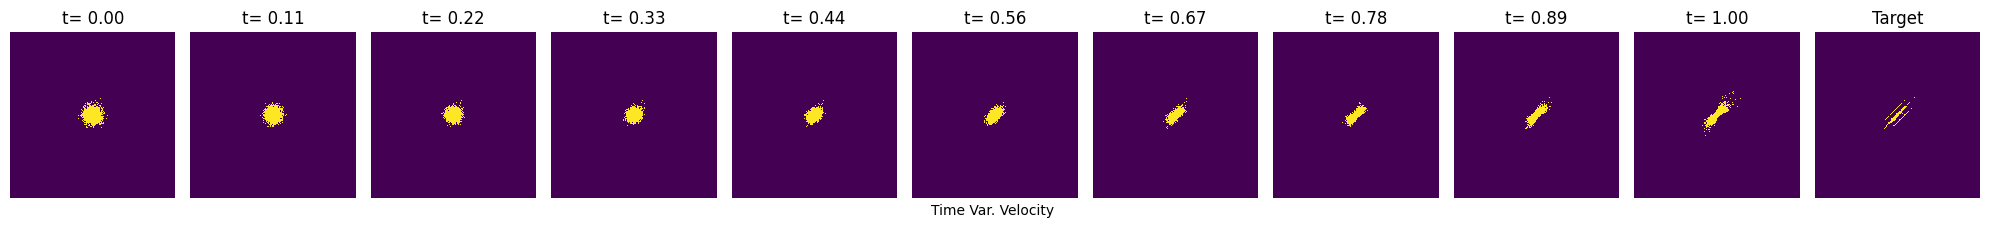

In [32]:

RR=x_lim
fig, axs = plt.subplots(1, 11,figsize=(20,20))

for i in range(11):
    # if i==10:
    #     H = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    # else:
    #     H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    cmin = 0.0
    cmax = 0.99#torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    if i==10:
        _ = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    else:
        _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    if i==10:
        axs[i].set_title('Target')
    else:

        axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
fig.text(0.5, 0.45, 'Time Var. Velocity ', ha='center')
plt.show()

In [33]:
full_data_test
generated_data=sol[9]

In [34]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

# grid_size = 200
# x_1 = torch.meshgrid(torch.linspace(-60, 60, grid_size), torch.linspace(-60, 60, grid_size))
# x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
x_1=torch.tensor(x_tst)[0:1000,:].to(device).float()
print(x_1.shape)

torch.Size([1000, 20])


C:\Users\adity\AppData\Local\Temp\ipykernel_22116\405170638.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_1=torch.tensor(x_tst)[0:1000,:].to(device).float()


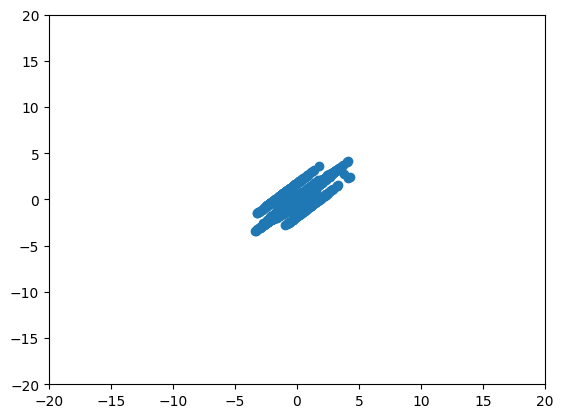

In [35]:
plt.scatter(full_data_test[:,0],full_data_test[:,1])
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-x_lim,x_lim))
plt.show()

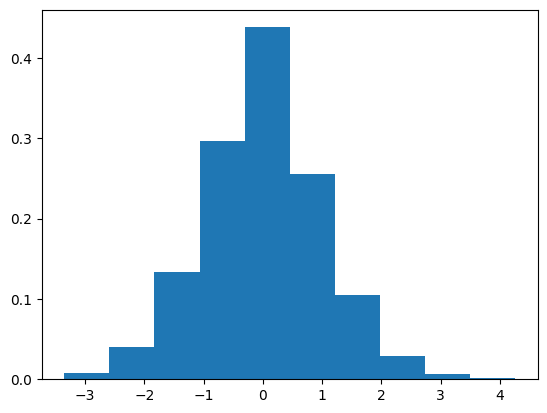

In [36]:


full_data_test.max()
plt.hist(full_data_test[:,0],density=True,bins=10)
plt.show()

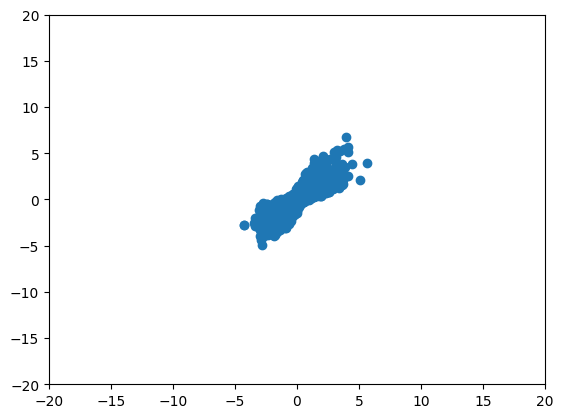

29.52

In [37]:
plt.scatter(generated_data[:,0],generated_data[:,1])
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-x_lim,x_lim))
plt.show()
generated_data.max()

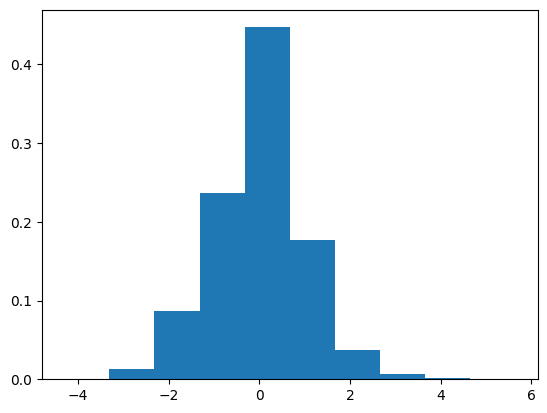

In [38]:



plt.hist(generated_data[:,0],density=True,bins=10)
plt.show()

In [39]:
full_data_test[:,0].min(),generated_data.min()

(tensor(-3.3534, dtype=torch.float64), -6.124042)

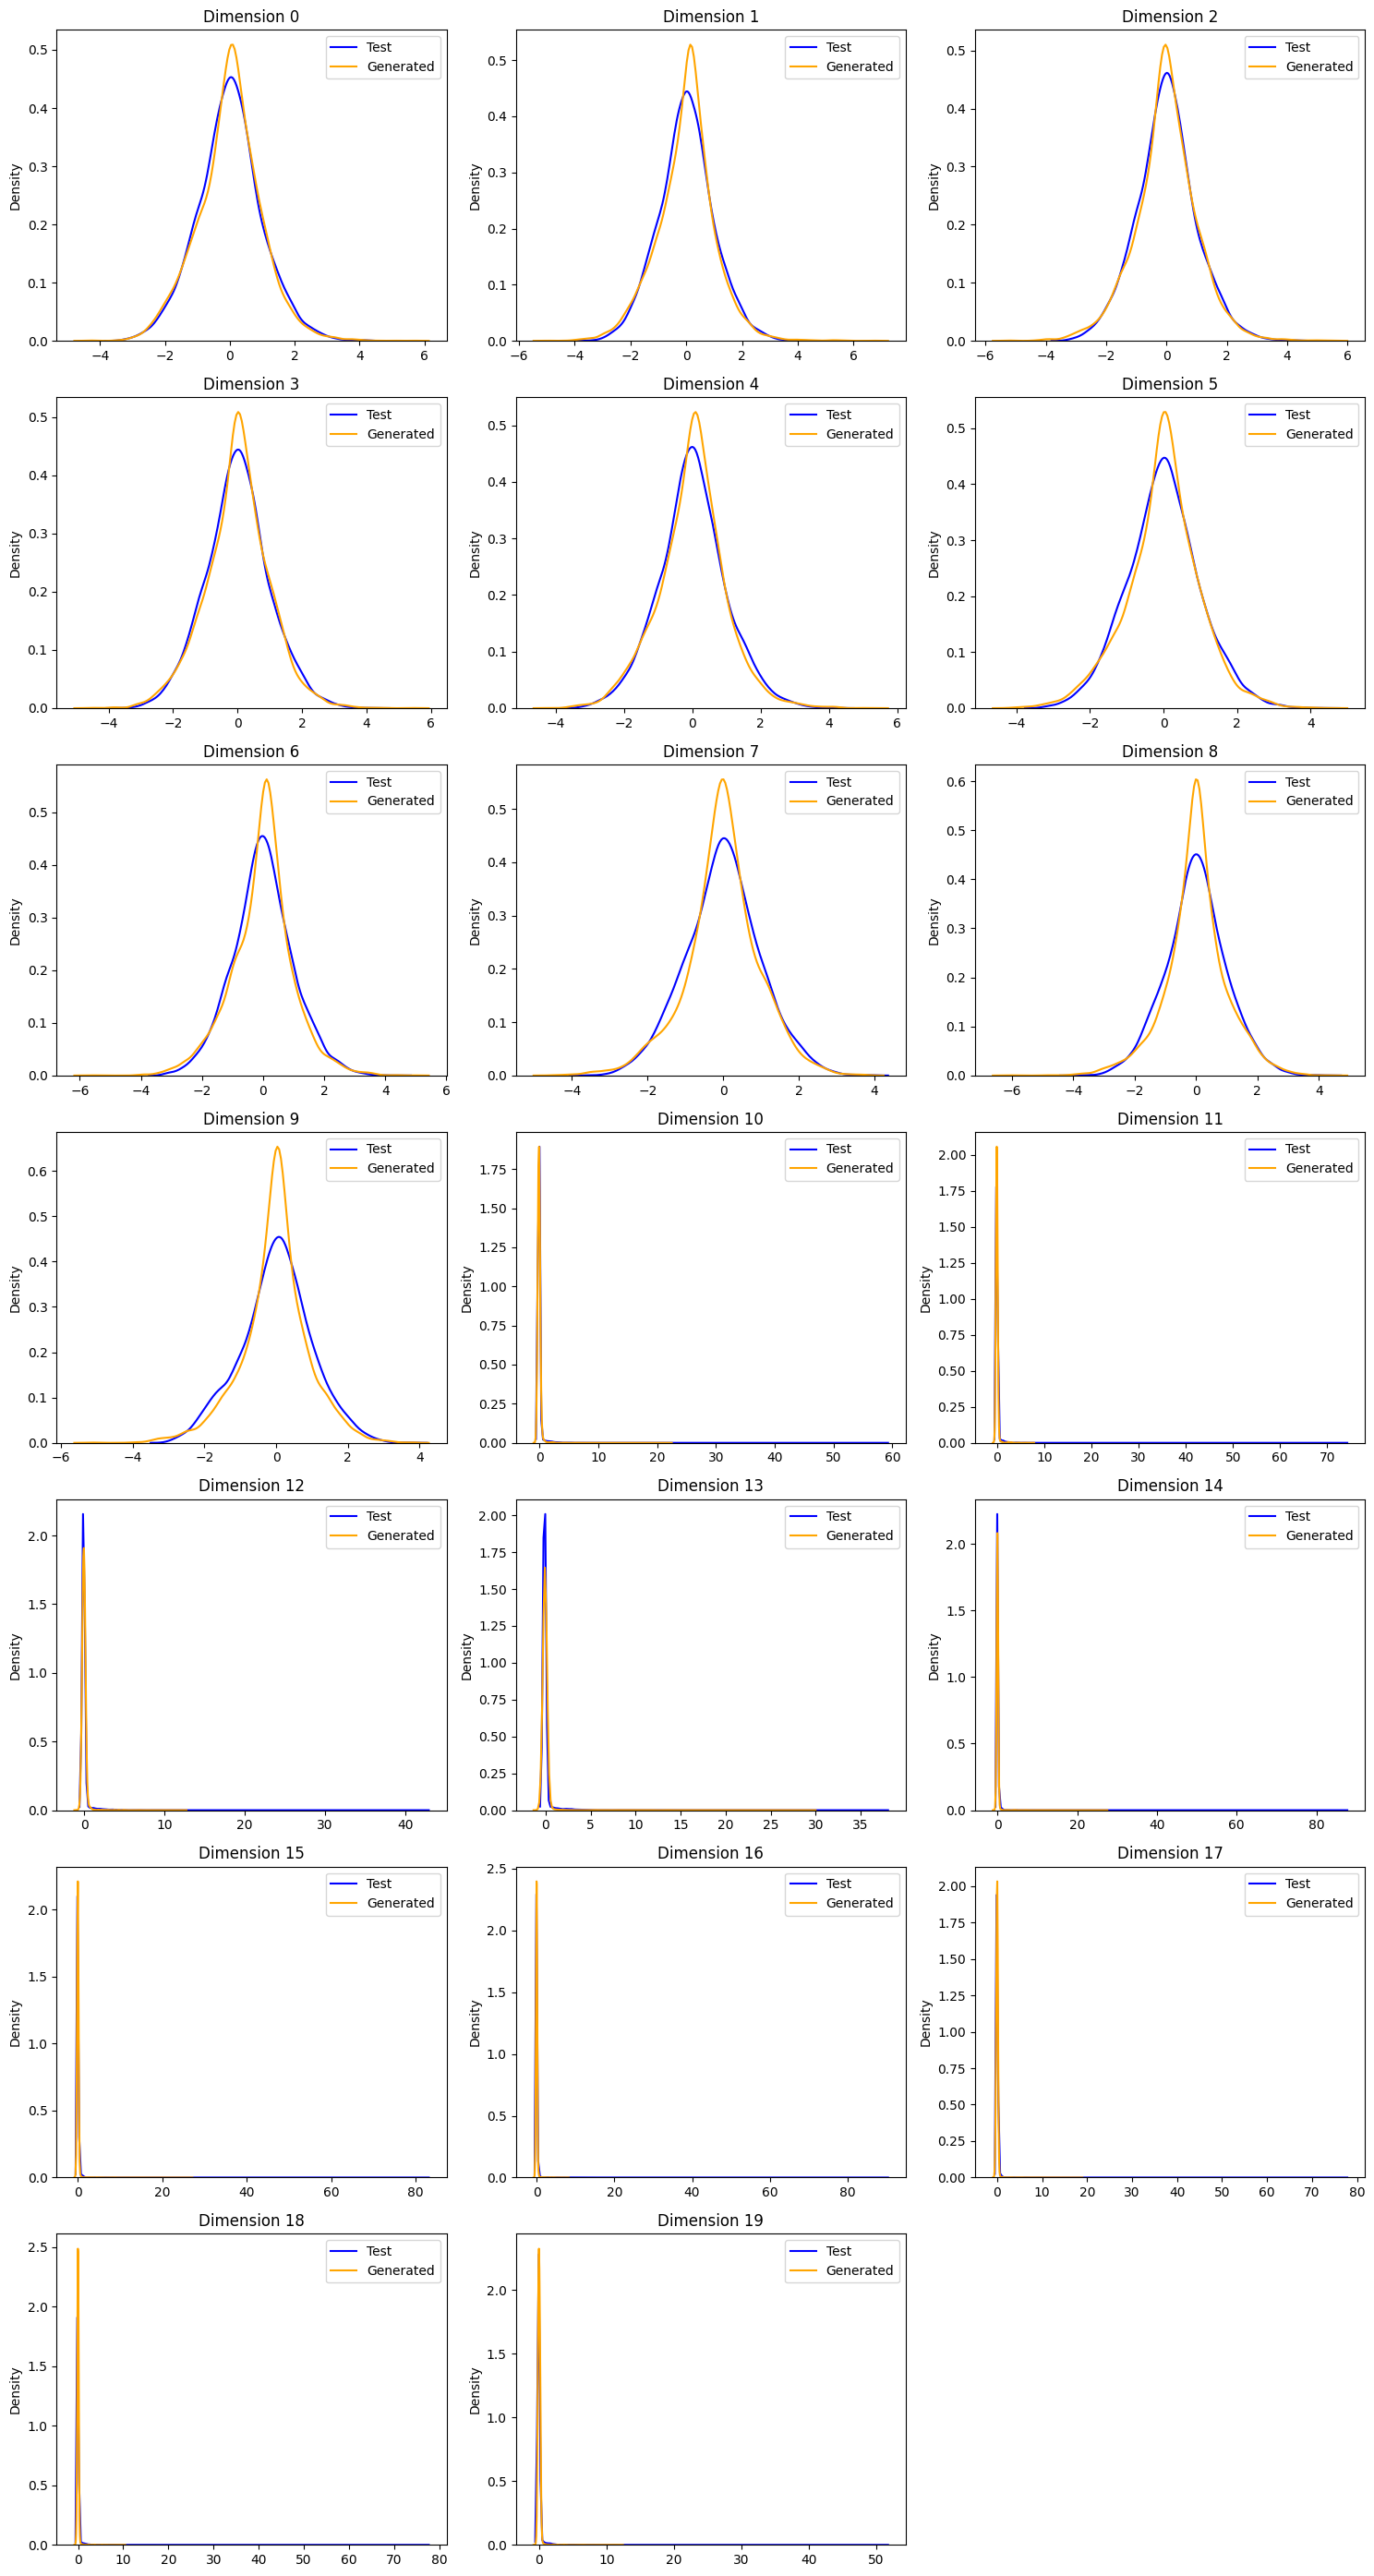

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kde_subplots(test_data, gen_data, n_cols=3, figsize=(15, 4), suptitle=None):
    """
    Plots KDE comparisons between test and generated data for each dimension.

    Parameters:
    - test_data: np.ndarray of shape (batch, dim)
    - gen_data: np.ndarray of shape (batch, dim)
    - n_cols: Number of columns in subplot grid
    - figsize: Tuple (width, height) for each subplot row
    - suptitle: Optional super title for the figure
    """
    assert test_data.shape == gen_data.shape, "test_data and gen_data must have the same shape"
    
    batch, dim = test_data.shape
    n_rows = (dim + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1]*n_rows))
    axes = axes.flatten()

    for i in range(dim):
        ax = axes[i]
        sns.kdeplot(np.clip(test_data[:, i],-200,200), ax=ax, label='Test', color='blue')
        sns.kdeplot(np.clip(gen_data[:, i],-200,200), ax=ax, label='Generated', color='orange')
        ax.set_title(f'Dimension {i}')
        ax.legend()

    # Remove unused axes
    for j in range(dim, len(axes)):
        fig.delaxes(axes[j])

    if suptitle:
        plt.suptitle(suptitle, fontsize=16)
        plt.subplots_adjust(top=0.92)

    plt.tight_layout()
    plt.show()

plot_kde_subplots(full_data_test,generated_data)

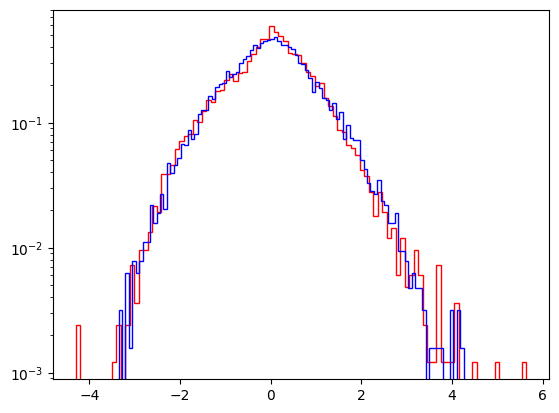

In [41]:

plt.hist(generated_data[:,0],density=True,bins=100,color='red',histtype='step')
plt.hist(full_data_test[:,0],density=True,bins=100,color='blue',histtype='step')
ax = plt.gca()  # Get current Axes
ax.set_yscale('log')
# plt.xlim(-200,200)


In [42]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(dimension, device=device), torch.ones(dimension, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p
    print(log_p)

log_p_acc /= num_acc

# compute with exact divergence
# _, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

tensor([ -23.3230,  -22.5302,  -22.9963,  -33.7671,  -20.1489,  -28.7526,
        -108.9987,  -19.6882,  -23.3277,  -30.6470,  -28.1543,  -20.3957,
         -22.8530,  -19.2652,  -20.4460,  -19.7092,  -31.0736,  -22.9353,
         -18.3783,  -41.9288,  -33.7404,  -27.6418,  -19.4644,  -19.9568,
         -19.8209,  -19.9091,  -19.6254,  -20.9324,  -71.2074,  -18.9759,
         -20.5596,  -19.2353,  -20.3808,  -20.4497, -150.1938,  -19.4555,
         -75.5280,  -19.9393,  -22.1016,  -20.5609,  -37.0366,  -20.7586,
         -63.4001,  -19.3118,  -20.2830,  -19.8875,  -63.5860,  -50.5472,
         -19.8977,  -20.7144,  -22.2497,  -20.4349,  -19.7943,  -20.8372,
         -43.0051,  -19.9017,  -33.0987,  -19.9351,  -19.2778,  -20.6917,
         -96.2869,  -20.0420,  -20.1158,  -77.7617,  -34.0616,  -19.1335,
         -85.3271,  -21.1814,  -20.0854,  -20.7491,  -19.1937,  -20.0762,
         -34.2255, -124.8126,  -19.1211,  -24.2557,  -26.7574,  -20.2758,
        -105.2342,  -58.8290,  -21.843

In [43]:
torch.sum(log_p_acc>log_p_acc.min()+10000)
mask=log_p_acc>log_p_acc.min()
zx=log_p_acc*mask 
zx.mean(),torch.sum(x_1>1000)

(tensor(-29.8493, device='cuda:0'), tensor(0, device='cuda:0'))

In [44]:
print(log_p_acc.median(),log_p_acc.mean())  #    queueu=-14 pareto A117.81
#-3725 rms
# -99 rms
#-14 rms
#-63 adam
#-59.8   or(-45058.3555, d -693.8184, tensor(-50.9519, device='cuda:0') -36 best with decreaseing linear sampling tensor(0.2530, device='cuda:0') -6.1681

tensor(-22.3732, device='cuda:0') tensor(-30.0256, device='cuda:0')


In [45]:
from extreme_transforms import softplus
TT = torch.linspace(0,1,10) 
softplus(Tail_paramNet(TT.unsqueeze(1).to(device))[:,0:4])

tensor([[0.0792, 0.0092, 0.0418, 0.0363],
        [0.1032, 0.0152, 0.0585, 0.0519],
        [0.1340, 0.0249, 0.0816, 0.0739],
        [0.1732, 0.0408, 0.1131, 0.1045],
        [0.2224, 0.0663, 0.1552, 0.1465],
        [0.2824, 0.1057, 0.2097, 0.2021],
        [0.3523, 0.1627, 0.2763, 0.2716],
        [0.4275, 0.2365, 0.3510, 0.3513],
        [0.4997, 0.3185, 0.4259, 0.4321],
        [0.5602, 0.3944, 0.4916, 0.5028]], device='cuda:0',
       grad_fn=<SoftplusBackward0>)

In [46]:
from extreme_transforms import softplus
TT = torch.linspace(0,1,10) 
softplus(Tail_paramNet(TT.unsqueeze(1).to(device))[:,0:4])

tensor([[0.0792, 0.0092, 0.0418, 0.0363],
        [0.1032, 0.0152, 0.0585, 0.0519],
        [0.1340, 0.0249, 0.0816, 0.0739],
        [0.1732, 0.0408, 0.1131, 0.1045],
        [0.2224, 0.0663, 0.1552, 0.1465],
        [0.2824, 0.1057, 0.2097, 0.2021],
        [0.3523, 0.1627, 0.2763, 0.2716],
        [0.4275, 0.2365, 0.3510, 0.3513],
        [0.4997, 0.3185, 0.4259, 0.4321],
        [0.5602, 0.3944, 0.4916, 0.5028]], device='cuda:0',
       grad_fn=<SoftplusBackward0>)

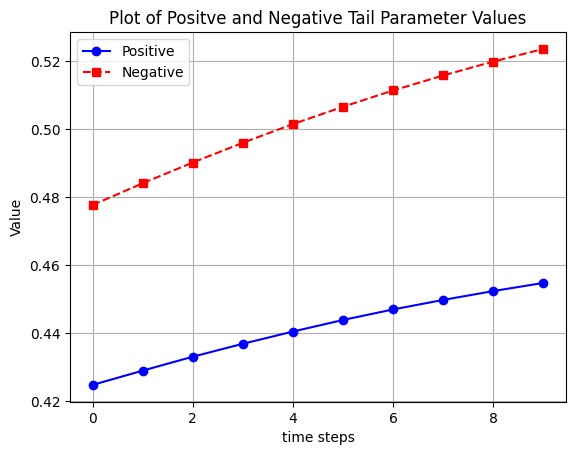

In [47]:
import matplotlib.pyplot as plt

# Given data
data = [[0.4248, 0.4167, 0.4777, 0.4127],
        [0.4290, 0.4229, 0.4841, 0.4221],
        [0.4331, 0.4286, 0.4902, 0.4310],
        [0.4369, 0.4340, 0.4960, 0.4394],
        [0.4405, 0.4390, 0.5015, 0.4472],
        [0.4439, 0.4434, 0.5066, 0.4545],
        [0.4470, 0.4474, 0.5114, 0.4611],
        [0.4498, 0.4509, 0.5158, 0.4672],
        [0.4524, 0.4540, 0.5199, 0.4726],
        [0.4548, 0.4565, 0.5236, 0.4775]]

# Extract first and second columns
first_column = [row[0] for row in data]
second_column = [row[2] for row in data]

# Plot
plt.plot(first_column, marker='o', linestyle='-', color='b', label="Positive")
plt.plot(second_column, marker='s', linestyle='--', color='r', label="Negative")

# Labels and title
plt.xlabel("time steps")
plt.ylabel("Value")
plt.title("Plot of Positve and Negative Tail Parameter Values")
plt.legend()
plt.grid(True)
plt.show()


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

def plot_wasserstein_distances(generate_data: np.ndarray, test_data: np.ndarray):
    """
    Computes and plots Wasserstein distances for each feature between generated and test data.

    Parameters:
    - generate_data: np.ndarray of shape (N, D)
    - test_data: np.ndarray of shape (N, D)
    """
    assert generate_data.shape[1] == test_data.shape[1], "Feature dimensions must match"
    num_features = generate_data.shape[1]
    
    distances = [
        wasserstein_distance(test_data[:, i], generate_data[:, i])
        for i in range(num_features)
    ]
    
    # Plot bar chart
    # plt.figure(figsize=(12, 6))
    # plt.bar(range(num_features), distances, color='skyblue')
    # plt.xlabel('Feature Index')
    # plt.ylabel('Wasserstein Distance')
    # plt.title('Wasserstein Distance per Feature Dimension')
    # plt.xticks(range(num_features))
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.tight_layout()
    # plt.show()
    
    return distances  # Optional: return the distances for further use


In [ ]:
wasdist_list=plot_wasserstein_distances(generated_data,full_data_test)
print(wasdist_list)
np.mean(wasdist_list)   #7.623988290672775  dof1A1-1.116690311340978  dof2A1-9.119758828227486 dof2A2 -7.23 ParetoA1-0.077 ParetoA2  checjk 0.54withchecker

#full pareto A1-0.02346
#cone A1-0.18 A2-0.24
# #hrrr Wd-0.111 KR-0.9512 SR-0.8589   vs base WD-0.09747168757370553 KR tensor(0.9948) SR 0.9616


[0.03594038157567836, 0.0649943223741129, 0.04113135200471907, 0.03926961585812628, 0.05350949938149812, 0.0606498080671999, 0.07702487710690785, 0.08278395296567954, 0.08921701771607589, 0.11903163462167513, 0.15891403543696037, 0.16020915905016603, 0.20013716985221974, 0.17918225811634597, 0.13795907556784295, 0.1286994584082583, 0.1321298011887158, 0.14986009469862874, 0.14564999921305968, 0.1617608054151143]


0.11090271593094925

In [50]:
full_data_val.shape,full_data_train.shape,full_data_test.shape

(torch.Size([16752, 20]), torch.Size([16752, 20]), torch.Size([8348, 20]))

In [51]:
np.save(Dataset+'_TTFgen.npy', generated_data)
np.save(Dataset+'_TTFtest.npy', full_data_test)

In [52]:
import torch
from scipy import stats

def compute_kurtosis_ratio(
    generated_data: torch.Tensor, 
    test_data: torch.Tensor,
    eps: float = 1e-8
) -> torch.Tensor:
    """
    Computes the Kurtosis Ratio (KR) using SciPy.
    Converts tensors to NumPy arrays for calculation.

    Args:
        generated_data (torch.Tensor): The data generated by the model.
        test_data (torch.Tensor): The underlying real data.
        eps (float): A small value for numerical stability.

    Returns:
        torch.Tensor: A scalar tensor containing the Kurtosis Ratio.
    """
    # 1. Flatten tensors and convert to NumPy arrays.
    # .cpu() is used in case the tensors are on a GPU.
    generated_np = generated_data.flatten().cpu().numpy()
    test_data_np = test_data.flatten().cpu().numpy()

    # 2. Compute empirical kurtosis (k_sim and k_data) using SciPy.
    # fisher=True computes excess kurtosis (kurtosis - 3), which is standard.
    # bias=True computes the biased estimator, consistent with moment calculations.
    k_sim = stats.kurtosis(generated_np, fisher=True, bias=True)
    k_data = stats.kurtosis(test_data_np, fisher=True, bias=True)

    # 3. Compute the Kurtosis Ratio.
    kr = abs(1 - (k_sim / (k_data + eps)))
    
    # 4. Convert the final result back to a PyTorch tensor.
    return torch.tensor(kr, dtype=torch.float32)

def compute_skewness_ratio(
    generated_data: torch.Tensor, 
    test_data: torch.Tensor,
    eps: float = 1e-8
) -> torch.Tensor:
    """
    Computes the Skewness Ratio (SR) using SciPy.
    Converts tensors to NumPy arrays for calculation.

    Args:
        generated_data (torch.Tensor): The data generated by the model.
        test_data (torch.Tensor): The underlying real data.
        eps (float): A small value for numerical stability.

    Returns:
        torch.Tensor: A scalar tensor containing the Skewness Ratio.
    """
    # 1. Flatten tensors and convert to NumPy arrays.
    generated_np = generated_data.flatten().cpu().numpy()
    test_data_np = test_data.flatten().cpu().numpy()

    # 2. Compute empirical skewness (s_sim and s_data) using SciPy.
    # bias=True computes the biased estimator.
    s_sim = stats.skew(generated_np, bias=True)
    s_data = stats.skew(test_data_np, bias=True)

    # 3. Compute the Skewness Ratio.
    sr = abs(1 - (s_sim / (s_data + eps)))

    # 4. Convert the final result back to a PyTorch tensor.
    return torch.tensor(sr, dtype=torch.float32)

In [53]:
compute_kurtosis_ratio(torch.tensor(generated_data),full_data_test)

tensor(0.9512)

In [54]:
compute_skewness_ratio(torch.tensor(generated_data),full_data_test)

tensor(0.8589)

In [55]:
import torch
from typing import Callable
from torch import nn, Tensor

def jvp(f,x, v) -> tuple[Tensor, ...]:
    return torch.autograd.functional.jvp(
        f, x, v, 
        create_graph=torch.is_grad_enabled()
    )


def t_dir(f, t) -> tuple[Tensor, ...]:
    return jvp(f, t, torch.ones_like(t))


def get_t_dir( x: Tensor, t: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
    def flow(a,b):
        return(b.unsqueeze(1)**a)
    def f(x_in):
        def f_(t_in):
            return flow(x_in, t_in)
        return f_

    return t_dir(f(x), t)


t=torch.asarray(list(torch.range(0,5)))
x=torch.zeros(6,2)+1
x[:,1]=3
print(t)
print("x",x)
l=get_t_dir(x,t)
print(l[0].shape,l[1].shape)


tensor([0., 1., 2., 3., 4., 5.])
x tensor([[1., 3.],
        [1., 3.],
        [1., 3.],
        [1., 3.],
        [1., 3.],
        [1., 3.]])
torch.Size([6, 2]) torch.Size([6, 2])


C:\Users\adity\AppData\Local\Temp\ipykernel_22116\1880281314.py:27: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t=torch.asarray(list(torch.range(0,5)))


In [83]:
vv=torch.randn(2,3,2,2)
qq=torch.randn(2,12,2,2)

In [86]:
vv[0,0:2,:,:]

tensor([[[-1.5698, -0.1481],
         [-1.4746,  0.3824]],

        [[ 1.1922,  0.1211],
         [-0.2369, -0.9054]]])

In [87]:
vv.reshape(2,-1)[0,0:8]

tensor([-1.5698, -0.1481, -1.4746,  0.3824,  1.1922,  0.1211, -0.2369, -0.9054])

In [72]:
qq[0,4:8,:,:]

tensor([[[ 0.3954,  1.5060],
         [ 0.0699, -0.9118]],

        [[ 1.5530,  0.2826],
         [ 2.1351, -2.6039]],

        [[ 0.1707,  1.7325],
         [-1.8028, -0.6949]],

        [[ 0.1610, -0.6672],
         [ 0.5538,  1.1528]]])

In [73]:
vv.reshape(2,-1)[0,:]

tensor([-0.5875, -0.1929,  0.1053,  0.0048,  0.1111,  0.1662, -0.7200,  0.9059,
         0.4293, -0.6689, -0.7486,  1.5633])

In [79]:
qq.permute(0,2,3,1).reshape(2,-1)[0,0:12]

tensor([ 1.0294, -1.7511,  0.6996,  0.5532,  0.3954,  1.5530,  0.1707,  0.1610,
        -0.1261, -0.3003, -0.8313,  0.8988])